# Objective
* 20190907:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * We use double exponential smoothing to predict
    * Here we include finetuning on the hyperparameters

In [251]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import time

from collections import defaultdict
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21
train_size = 756              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

# alpha - smoothing coeff
alphaMax = 0.999
alphaMin = 0.01
alphaStep = 0.01

# beta - trend coeff
betaMax = 0.999
betaMin = 0.01
betaStep = 0.01

# for plot display
daysBackward = 30
daysForward = 60

i_list = range(1008, 1008+84*5+42+1, 42) # we want to do a forecast on these days

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [252]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [253]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def double_exponential_smoothing(series, H, alpha=0.3, beta=0.3, return_all=False):
    """
    Given a series and alpha, return series of smoothed points
    Initialization: 
    S_1 = y_1, 
    b_1 = y_2 - y_1, 
    F_1 = 0, F_2 = y_1
    level, S_t = alpha*y_t + (1-alpha)*(S_t-1 + b_t-1)
    trend, b_t = beta*(S_t - S_t-1) + (1-beta)*b_t-1
    forecast, F_t+1 = S_t + b_t
    forecast, F_t+m = S_t + m*b_t
    result[len(series)] is the estimate of series[len(series)]
    Inputs
        series: series to forecast
        H     : forecast horizon
        alpha : smoothing constant. 
                When alpha is close to 1, dampening is quick. 
                When alpha is close to 0, dampening is slow
        beta  : smoothing constant for trend
        return_all : if 1 return both original series + predictions, if 0 return predictions only
    Outputs
        the predictions of length H
    """
    result = [0, series[0]]   
    level = series[0]
    trend = [series[1] - series[0]]
    for n in range(1, len(series)+H-1):            
        if n >= len(series): # we are forecasting
            m = n - len(series) + 2
            result.append(level + m*trend[-1]) # result[len(series)+1] is the estimate of series[len(series)+1]
        else:
            value = series[n]
            last_level = level
            level = alpha*value + (1-alpha)*(last_level+trend[n-1])
            trend.append(beta*(level-last_level) + (1-beta)*trend[n-1])
            result.append(level+trend[n]) 
            # e.g. result[2] uses series[1] 
            # ie. result[2] is the estimate of series[2]
            # e.g. result[len(series)] uses series[len(series)-1] 
            # ie. result[len(series)] is the estimate of series[len(series)]
    
    if return_all == True:
        return result, trend
    else:
        return result[len(series):len(series)+H], trend


def get_error_metrics(series, train_size, H, alpha, beta):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        H          : forecast horizon
        alpha      : smoothing coeff
        beta       : trend coeff
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    # Predict using single exponential smoothing, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    for i in range(train_size, len(series)-H+1, int(H/2)):
        preds_list, trend = double_exponential_smoothing(series[i-train_size:i], H, alpha, beta)
        
        rmse.append(get_rmse(series[i:i+H], preds_list))
        mape.append(get_mape(series[i:i+H], preds_list))
        mae.append(get_mae(series[i:i+H], preds_list))
        preds_dict[i] = preds_list
    
    return np.mean(rmse), np.mean(mape), np.mean(mae), preds_dict    

In [254]:
def hyperparam_tune_alpha_beta_finetune(series, train_size, H):
    """
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        H          : forecast horizon
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        beta = betaMin
        while beta <= betaMax:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(series, train_size, H, alpha, beta)
        
            # Append alpha and beta
            err_dict['alpha'].append(alpha)
            err_dict['beta'].append(beta)
    
            # Compute error metrics
            err_dict['rmse'].append(rmse_mean)
            err_dict['mape'].append(mape_mean)
            err_dict['mae'].append(mae_mean)
            
            # Increase beta by one step
            beta = beta + betaStep
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    err_df = pd.DataFrame(err_dict)
    
    # Get min RMSE
    rmse_min = err_df['rmse'].min()
    
    alpha_opt = err_df[err_df['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt = err_df[err_df['rmse'] == rmse_min]['beta'].values[0]
    
    #finetune
    err_dict_finetune = defaultdict(list)
    finetune_width = 0.01
    finetune_step = 0.001
    alpha = max(0, alpha_opt - finetune_width)
    while alpha <= min(1, alpha_opt + finetune_width):
        beta = max(0, beta_opt - finetune_width)
        while beta <= min(1, beta_opt + finetune_width):
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(series, train_size, H, alpha, beta)
        
            # Append alpha and beta
            err_dict_finetune['alpha'].append(alpha)
            err_dict_finetune['beta'].append(beta)
    
            # Compute error metrics
            err_dict_finetune['rmse'].append(rmse_mean)
            err_dict_finetune['mape'].append(mape_mean)
            err_dict_finetune['mae'].append(mae_mean)
            
            # Increase beta by one step
            beta = beta + finetune_step
        
        # Increase alpha by one step
        alpha = alpha + finetune_step
        
    # Convert to dataframe
    err_df_finetune = pd.DataFrame(err_dict_finetune)
    
    # Get min RMSE
    rmse_min = err_df_finetune['rmse'].min()
    
    return err_df_finetune[err_df_finetune['rmse'] == rmse_min]['alpha'].values[0], \
           err_df_finetune[err_df_finetune['rmse'] == rmse_min]['beta'].values[0], \
           err_df_finetune

# Load data

In [255]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [256]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

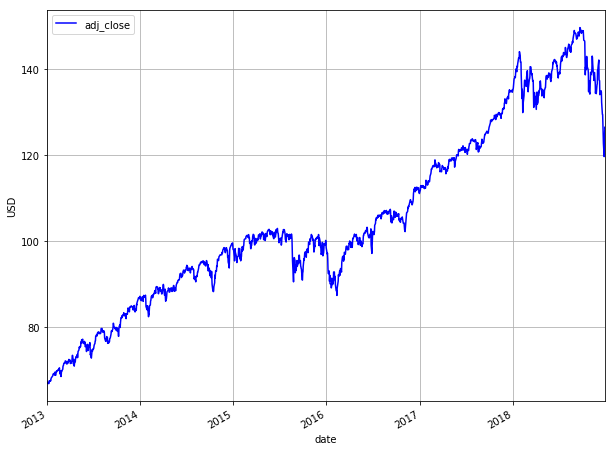

In [257]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict for a specific H (forecast horizon) and a specific date, plot original series too

In [258]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [259]:
# Predict
preds_list, trend = double_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, H, 0.3, 0.01, True)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.560558
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 0.391001
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 0.442508


(736116.0, 736361.0)

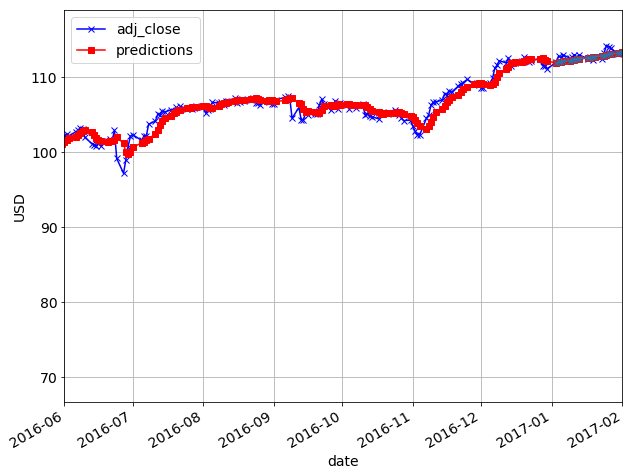

In [260]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i-train_val_size:i+H], preds_list, marker='s', color='r')
ax.plot(df['date'][i:i+H], preds_list[train_val_size:train_val_size+H], marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i-train_val_size+1], df['date'][i]+timedelta(days=H)])
ax.set_xlim(['2016-06-01', '2017-02-01'])
# ax.set_ylim([60, 85])

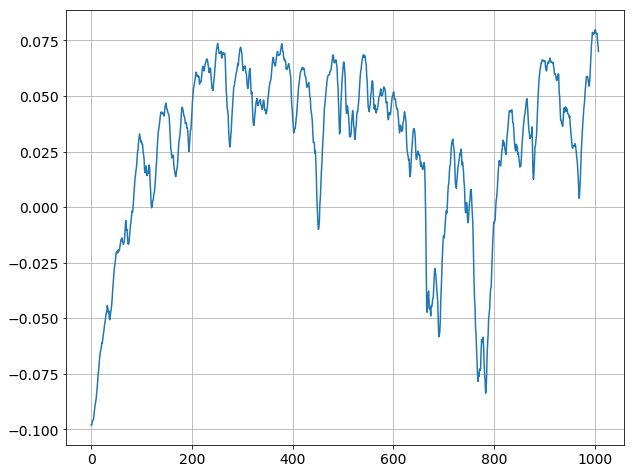

In [261]:
# Plot the trend
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

plt.plot(trend)
plt.grid()
# plt.xlim([0, 252])

# Predict for a specific H (forecast horizon) and a specific date

In [262]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [263]:
# Predict
preds_list, trend = double_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, H)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 3.858299
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 3.107412
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 3.514633


(736302.0, 736392.0)

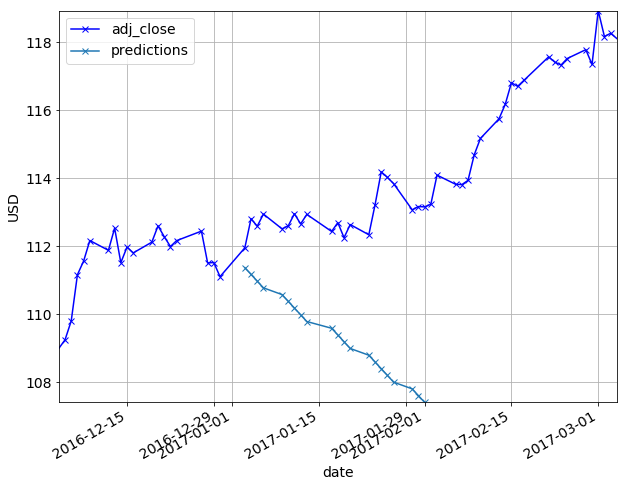

In [264]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning and finetuning - alpha, beta

In [265]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [266]:
# Get optimum hyperparams
tic = time.time()
alpha_opt, beta_opt, err_df = hyperparam_tune_alpha_beta_finetune(df['adj_close'][i-train_val_size:i].values, train_size, H)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))
print("rmse opt = " + str(err_df[(err_df['alpha']==alpha_opt) & (err_df['beta']==beta_opt)]['rmse'].values[0]))
err_df

Time taken = 4.554983647664388 mins
alpha_opt = 0.9990000000000007
beta_opt = 0.004
rmse opt = 2.098234044804707


,alpha,beta,rmse,mape,mae
0,0.980,0.000,6.089088,5.323161,5.391071
1,0.980,0.001,3.460207,3.045285,3.062926
2,0.980,0.002,2.452039,2.124710,2.122814
3,0.980,0.003,2.145358,1.864678,1.858970
4,0.980,0.004,2.101583,1.837582,1.833118
5,0.980,0.005,2.106609,1.848350,1.844776
6,0.980,0.006,2.119695,1.861791,1.858581
7,0.980,0.007,2.133514,1.874280,1.871256
8,0.980,0.008,2.146913,1.886243,1.883308
9,0.980,0.009,2.159836,1.897834,1.894905


In [267]:
# Predict
preds_list, trend = double_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, H, alpha_opt, beta_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 1.410566
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.181505
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 1.335960


(736302.0, 736392.0)

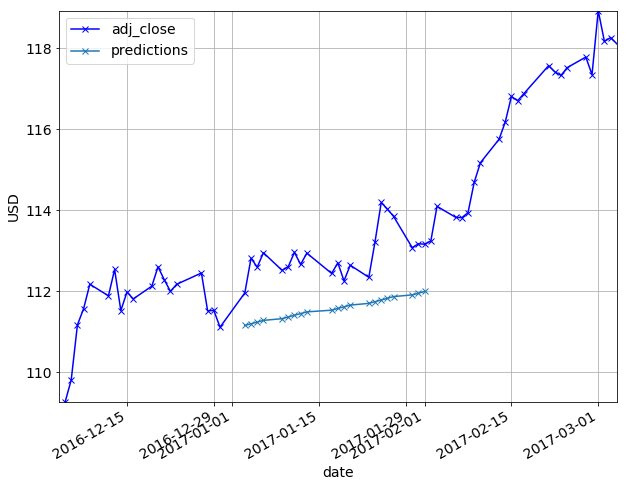

In [268]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [269]:
print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))

alpha_opt = 0.9990000000000007
beta_opt = 0.004


In [270]:
# Predict and compute error metrics also
preds_dict = {}
results_final_no_tune = defaultdict(list)
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
        
    preds_list, trend = double_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, H, alpha_opt, beta_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final_no_tune['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['day'].append(df.iloc[i]['date'])
    
results_final_no_tune = pd.DataFrame(results_final_no_tune)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final_no_tune), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [271]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final_no_tune['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final_no_tune['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final_no_tune['mae'].mean()))

For forecast horizon 21, the mean RMSE is 2.268293
For forecast horizon 21, the mean MAPE is 1.508319
For forecast horizon 21, the mean MAE is 2.023336


In [272]:
results_final_no_tune['alpha_opt'] = [alpha_opt]*len(i_list)
results_final_no_tune['beta_opt'] = [beta_opt]*len(i_list)
results_final_no_tune

,rmse,mape,mae,day,alpha_opt,beta_opt
0,1.410566,1.181505,1.335960,2017-01-03,0.999,0.004
1,1.955931,1.496315,1.749732,2017-03-06,0.999,0.004
2,0.782876,0.450439,0.536217,2017-05-04,0.999,0.004
3,0.946382,0.693987,0.853355,2017-07-05,0.999,0.004
4,1.032812,0.746769,0.935404,2017-09-01,0.999,0.004
5,0.852005,0.463710,0.607125,2017-11-01,0.999,0.004
6,4.298700,2.781317,3.932005,2018-01-03,0.999,0.004
7,4.050913,2.393824,3.205878,2018-03-06,0.999,0.004
8,4.453804,3.118447,4.314937,2018-05-04,0.999,0.004
9,3.842527,2.603478,3.734827,2018-07-05,0.999,0.004


(736302.0, 737059.0)

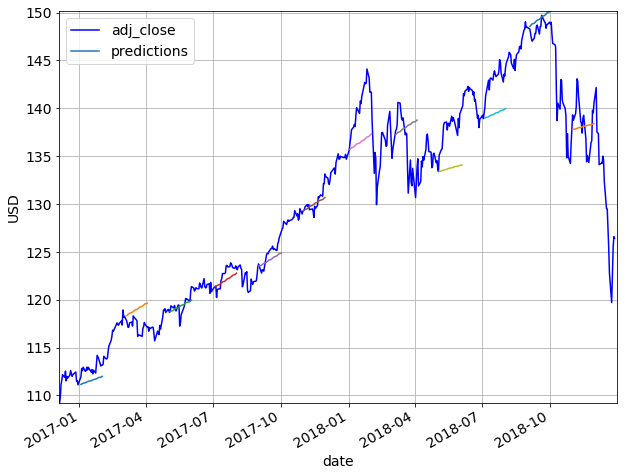

In [273]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.set_xlim([firstDay, lastDay]) 

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [274]:
# Predict and compute error metrics also
preds_dict = {}
results_final = defaultdict(list)
tic = time.time()
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
    
    # Get optimum hyperparams
    alpha_opt, beta_opt, err_df = hyperparam_tune_alpha_beta_finetune(df['adj_close'][i-train_val_size:i].values, train_size, H)
        
    preds_list, trend = double_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, H, alpha_opt, beta_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final['alpha_opt'].append(alpha_opt)
    results_final['beta_opt'].append(beta_opt)
    results_final['day'].append(df.iloc[i]['date'])

results_final = pd.DataFrame(results_final)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final), H))

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")


Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days
Time taken = 53.874979567527774 mins


In [275]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final['mae'].mean()))

For forecast horizon 21, the mean RMSE is 2.288867
For forecast horizon 21, the mean MAPE is 1.525507
For forecast horizon 21, the mean MAE is 2.040515


In [276]:
# results
results_final

,rmse,mape,mae,alpha_opt,beta_opt,day
0,1.410566,1.181505,1.335960,0.999,0.004,2017-01-03
1,2.296909,1.771310,2.071805,0.425,0.008,2017-03-06
2,0.796732,0.442346,0.525794,0.710,0.006,2017-05-04
3,1.024735,0.752802,0.926037,0.835,0.005,2017-07-05
4,1.091452,0.787956,0.987210,0.999,0.006,2017-09-01
5,0.860508,0.469438,0.614732,0.620,0.004,2017-11-01
6,4.238229,2.778626,3.925854,0.357,0.010,2018-01-03
7,4.075415,2.406407,3.222453,0.999,0.005,2018-03-06
8,4.376958,3.065791,4.241983,0.999,0.006,2018-05-04
9,3.799984,2.574885,3.693764,0.999,0.008,2018-07-05


(736302.0, 737059.0)

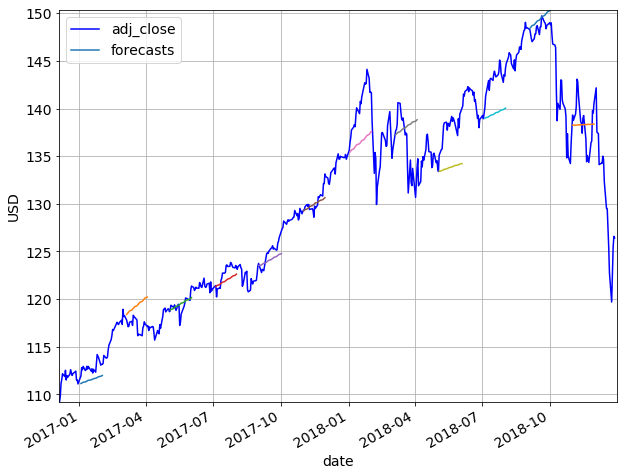

In [277]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.legend(['adj_close', 'forecasts'])
ax.set_xlim([firstDay, lastDay]) 

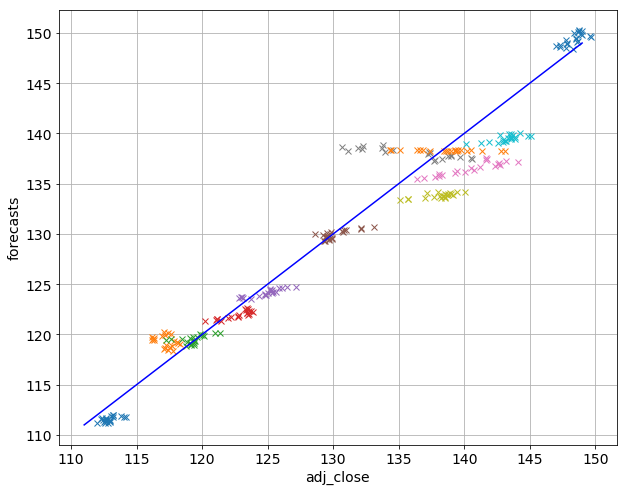

In [278]:
# Plot scatter plot of actual values vs. predictions
for key in preds_dict:
    plt.plot(df['adj_close'][key:key+H], preds_dict[key], 'x')
    
plt.plot(range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 
         range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 'b-')
    
plt.xlabel('adj_close')
plt.ylabel('forecasts')
plt.grid()

# Findings

In [279]:
train_size

756

In [280]:
val_size

252

In [282]:
# Collect the results from various experiments. Note results below are with fine-tuning of hyperparams
# # alpha - smoothing coeff
# alphaMax = 0.999
# alphaMin = 0.01
# alphaStep = 0.01

# # beta - trend coeff
# betaMax = 0.999
# betaMin = 0.01
# betaStep = 0.01
results_dict = pd.DataFrame({'train_size': [63, 126, 126, 126, 756, 756, 756, 756],
                             'val_size': [21, 21, 42, 63, 21, 63, 126, 252],
                             'before_tune_rmse': [4.377599, 4.377592, 7.660156, 5.633275, 4.377592, 3.388246, 2.961509, 2.268293],
                             'after_tune_rmse': [4.007767, 4.156697, 5.806814, 3.811439, 3.878356, 2.642692, 3.211803, 2.288867]})
results_dict

,train_size,val_size,before_tune_rmse,after_tune_rmse
0,63,21,4.377599,4.007767
1,126,21,4.377592,4.156697
2,126,42,7.660156,5.806814
3,126,63,5.633275,3.811439
4,756,21,4.377592,3.878356
5,756,63,3.388246,2.642692
6,756,126,2.961509,3.211803
7,756,252,2.268293,2.288867
